ROC and PR Curves 

made by Enrique Barreiro Limón

---

# **Introducción**

La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

El archivo de los datos está en Canvas y se llama "oil-spill.csv".


En la siguiente liga se encuentra la liga del artículo relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico. La última columna es de valor 1 (hay derrame en esa sección de la imagen) o 0 (no hay derrame en esa sección de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

En la siguiente liga puedes encontrar información de varias de las métricas que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La media geométrica se puede obtener combinando las métricas anteriores, pero para fines prácticos usaremos la de la librería llamada "imbalanced-learn":

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

In [1]:
# Incluye todas las librerías que consideres adecuadas:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import read_csv
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

In [2]:
# Abrimos el Archivo CSV en un DataFrame

oil_spill_data = pd.read_csv('oil_spill.csv', header=None)
oil_spill_data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,200,12,92.42,364.42,135,97200.0,59.42,10.34,884.0,0.17,...,381.84,254.56,84.85,146.97,4.50,0,2593.50,65.85,6.39,0
933,201,11,98.82,248.64,159,89100.0,59.64,10.18,831.0,0.17,...,284.60,180.00,150.00,51.96,1.90,0,4361.25,65.70,6.53,0
934,202,14,25.14,428.86,24,113400.0,60.14,17.94,847.0,0.30,...,402.49,180.00,180.00,0.00,2.24,0,2153.05,65.91,6.12,0
935,203,10,96.00,451.30,68,81000.0,59.90,15.01,831.0,0.25,...,402.49,180.00,90.00,73.48,4.47,0,2421.43,65.97,6.32,0


In [3]:
# Obtenemos las estadísticas descriptivas de las variables numéricas en el DataFrame
descriptive_stats = oil_spill_data.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
0,937.0,81.588047,6.497673e+01,1.00,31.00,64.00,124.00,352.00
1,937.0,332.842049,1.931939e+03,10.00,20.00,65.00,132.00,32389.00
2,937.0,698.707086,5.999656e+02,1.92,85.27,704.37,1223.48,1893.08
3,937.0,870.992209,5.227993e+02,1.00,444.20,761.28,1260.37,2724.57
4,937.0,84.121665,4.536177e+01,0.00,54.00,73.00,117.00,180.00
5,937.0,769696.378869,3.831151e+06,70312.00,125000.00,186300.00,330468.00,71315000.00
6,937.0,43.242721,1.271840e+01,21.24,33.65,39.97,52.42,82.64
7,937.0,9.127887,3.588878e+00,0.83,6.75,8.20,10.76,24.69
8,937.0,3940.712914,8.167428e+03,667.00,1371.00,2090.00,3435.00,160740.00
9,937.0,0.221003,9.031555e-02,0.02,0.16,0.20,0.26,0.74


In [4]:
# Calculamos la cantidad de valores faltantes para cada columna usando isna()
missing_values = oil_spill_data.isna().sum()

# Creamos un DataFrame para mostrar los resultados
missing_values_df = pd.DataFrame(missing_values, columns=['missing_count'])
missing_values_df['missing_percentage'] = (missing_values_df['missing_count'] / len(oil_spill_data)) * 100

# Mostramos el DataFrame con el conteo y porcentaje de valores faltantes
missing_values_df

,missing_count,missing_percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [5]:
# Observamos la estructura y contenido del data frame

print("Dimensión del DataFrame: \n",oil_spill_data.shape)

Dimensión del DataFrame: 
 (937, 50)


In [6]:
# Eliminamos columnas innecesarias

oil_spill_data.drop(22, axis=1, inplace=True)    # Eliminamos la columna 22 tiene un solo valor constante.
oil_spill_data.drop(0, axis=1, inplace=True)     # La columna 0 contiene información de secciones (batches) de las imágenes, que no la requerimos.

oil_spill_data.columns = [i for i in range(oil_spill_data.shape[1])] # Renombramos las columnas con índices consecutivos.

In [7]:
# Separamos los datos en variables de entrada (X) y salida (y)

X,y = oil_spill_data.iloc[:,:-1], oil_spill_data.iloc[:,-1] 

# Para las variables de entrada toma todas las columnas excepto la última 
# Para la variable de salida toma únicamente la última columna


# Se divide el dataset en Xtv (train + validación) y Xtest (test), dejando el 12% de los datos para test.

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)

# Se divide Xtv en Xtrain (entrenamiento) y Xval (validación), asignando el 20% para validación.

Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)

#  Imprimimos el conteo de la clase positiva en cada subconjunto

print('\nPartición:')
print('Train: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytrain.sum(), 100*(ytrain.sum() / len(ytrain))))
print('Val: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (yval.sum(), 100*(yval.sum() / len(yval))))
print('Test: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytest.sum(), 100*(ytest.sum() / len(ytest))))


Partición:
Train: Conteo clase positiva=29, Porcentaje=4.40%
Val: Conteo clase positiva=7, Porcentaje=4.24%
Test: Conteo clase positiva=5, Porcentaje=4.42%


In [8]:
# Obtenemos las estadísticas descriptivas del conjunto de entrenamiento

Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


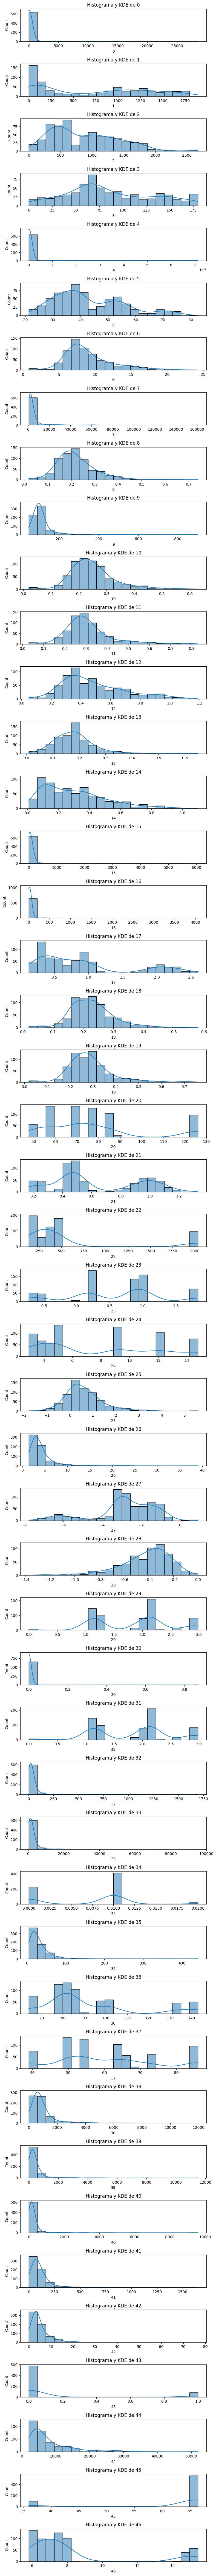

In [9]:
# Crear una figura para múltiples subgráficos
fig, axes = plt.subplots(nrows=len(Xtrain.columns), figsize=(8, 2 * len(Xtrain.columns)))

# Generar histogramas con KDE para cada variable
for col, ax in zip(Xtrain.columns, axes):
    sns.histplot(Xtrain[col], ax=ax, bins=20, kde=True, edgecolor='black')
    ax.set_title(f'Histograma y KDE de {col}')

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [10]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

### **Ejercicio - 1**

In [11]:
from numpy import mean, std

# Definimosla función evaluate_model()

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # Dividimos los datos en 10 partes y usamos cada una como test en iteraciones distintas, repitiendo la validación cruzada 3 veces.
  metric = make_scorer(geometric_mean_score) # Usamos la métrica G-mean, para medir el balance entre sensibilidad y especificidad.
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1) # Evalúamos el modelo con validación cruzada y devolvemos un arreglo de puntajes.
  return scores


modeloD = DummyClassifier(strategy='uniform') # Creamos un modelo Dummy que predice aleatoriamente con igual probabilidad para cada clase.
scores = evaluate_model(X, y, modeloD) # Evaluamos el modelo Dummy con la función evaluate_model()

print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (mean(scores), std(scores))) # Imprimimos la media y desviación estándar de los puntajes obtenidos.

Métrica G-mean - Media Geométrica: 0.461 (0.180)


La _G-Mean_ (media geométrica) es una métrica utilizada en problemas de clasificación desbalanceados, donde una clase es mucho más frecuente que la otra. Se define como:

$$
G Mean = \sqrt{Sensibilidad \times Especificidad}
$$

- **Sensibilidad (Recall de la clase positiva):** Qué tan bien el modelo identifica correctamente los casos positivos.
- **Especificidad (Recall de la clase negativa):** Qué tan bien el modelo identifica correctamente los casos negativos.

El valor ideal de G-Mean es 1.0 (100%), lo que indicaría que el modelo tiene un balance perfecto entre sensibilidad y especificidad.


El modelo _Dummy_ es muy básico ya que _strategy='uniform'_ significa que el clasificador asigna etiquetas al azar, sin aprender nada de los datos. 
- El 50.4% indica que su desempeño es cercano al azar, lo cual es esperado en un modelo Dummy.
- Asimismo, un G-Mean de 0.504 sugiere que el modelo no logra capturar bien ambas clases.
- Si el modelo fuera consistente, la desviación estándar sería baja, pero como la desviación es 13.1%, significa que el rendimiento varió entre los diferentes subconjuntos de la validación cruzada.

Como conclusión, para mejorar, se necesita un modelo más sofisticado, como un árbol de decisión, SVM, o una red neuronal. Probar diferentes estrategias para datos desbalanceados, como:
- Oversampling (aumentar los datos de la clase minoritaria).
- Undersampling (reducir los datos de la clase mayoritaria).
- Ajustar pesos de clase (class_weight='balanced' en modelos de scikit-learn).

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Transforamaciones numéricas

# Se usa un Pipeline para aplicar dos transformaciones a las variables numéricas:
numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')), # Se reemplazan los valores nulos con la media de la columna.
                                       ('std_transformer', StandardScaler())]) # Se restablece la media de cada columna a 0 y su desviación estándar a 1.

# Guardamos los nombres de las columnas de Xtrain para asegurarnos que las transformaciones se apliquen a todas las variables numéricas.
numericas_pipeline_nombres = Xtrain.columns

# Aplicamos diferentes transformaciones a diferentes tipos de columnas
columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)], #  Aplicamos numericas_pipeline a las columnas numéricas.
                                        remainder='passthrough') # Mantenemos sin cambios las columnas que no están en numericas_pipeline_nombres (como variables categóricas).

In [13]:
mi_metrica = make_scorer(geometric_mean_score)  # Definimos la métrica G-mean

### **Ejercicio - 2**

Resultados de Validación:
LR
Exactitud: >> 0.952 (0.015)
G-mean: >> 0.759 (0.087)

LASSO
Exactitud: >> 0.968 (0.009)
G-mean: >> 0.689 (0.104)

RIDGE
Exactitud: >> 0.969 (0.011)
G-mean: >> 0.725 (0.108)

EN
Exactitud: >> 0.968 (0.010)
G-mean: >> 0.694 (0.112)

kNN
Exactitud: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



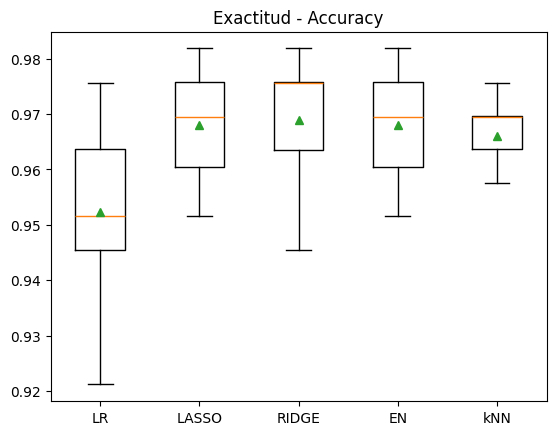

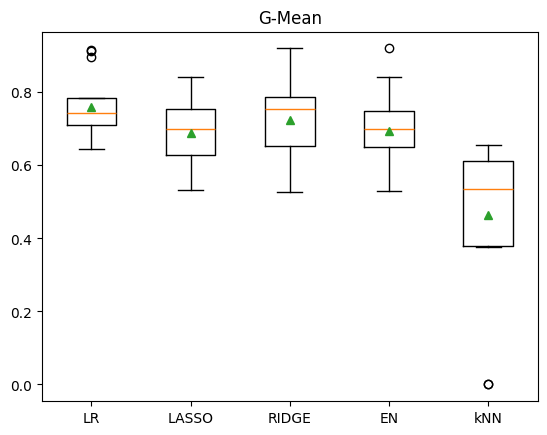

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

# Este código - 2 entrena y evalúa múltiples modelos de clasificación para el problema de clasificación desbalanceada, 
# utilizando validación cruzada repetida y comparando el desempeño con dos métricas: Exactitud y Media geométrica (G-Mean)

def mis_modelos1(): # Definimos una función que devuelve una lista de modelos y sus nombres correspondientes.
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None, # Regresión logística estándar.
                                    max_iter=2000, # 2000 iteraciones para garantizar convergencia.
                                    random_state=1)) # Semilla aleatoria para reproducibilidad.
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1', # Eliminamos las características irrelevantes usando LASSO.
                                    solver='liblinear', # Usamos el solucionador liblinear para LASSO (Obligatorio para L1).
                                    max_iter=2000, # 2000 iteraciones para garantizar convergencia.
                                    random_state=1)) # Semilla aleatoria para reproducibilidad.
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2', # Regresión logística con regularización Ridge (reduce el sobreajuste)
                                    max_iter=2000, # 2000 iteraciones para garantizar convergencia.
                                    random_state=1)) # Semilla aleatoria para reproducibilidad.
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet', # Regresión logística con regularización ElasticNet (combina L1 y L2)
                                    l1_ratio=0.5, # Proporción de regularización L1 (0.5 = mitad L1, mitad L2)
                                    solver='saga', # Solucionador para regularización ElasticNet
                                    max_iter=5000, # 5000 iteraciones para garantizar convergencia.
                                    random_state=1)) # Semilla aleatoria para reproducibilidad.
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5)) # Usa los 5 vecinos más cercanos para clasificar. No necesita entrenamiento previo, pero es sensible a la escala de los datos.
  nombres.append('kNN')

  return modelos, nombres

# Creación de Pipeline y Validación Cruzada

modelos, nombres = mis_modelos1() # Obtenemos los modelos y nombres de la función mis_modelos1()
resultados1, resultados2 = list(), list() # Creamos dos listas vacías para almacenar los resultados de las métricas Exactitud y G-mean.
print('Resultados de Validación:')

# Bucle para Evaluar Cada Modelo
for i in range(len(modelos)): # Itera sobre cada modelo en la lista.

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])]) # Creamos un Pipeline que aplica las transformaciones y el modelo en cada iteración (imputación + estandarización).
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7) # Validación cruzada repetida con 5 divisiones (K-fold) y 3 repeticiones.
  scores = cross_validate(pipeline, # Evaluamos el modelo con validación cruzada y devolvemos un diccionario de puntajes.
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica}, # Usamos la métrica G-mean y Exactitud.
                          cv=cv1)

  # Guardamos los resultados de cada modelo
  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  # Imprimimos los resultados mostrando la media y desviación estándar 
  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

# Visualización de Resultados 
plt.boxplot(resultados1, tick_labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, tick_labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()

Los resultados y gráficos anteriores muestran que la exactitud (Accuracy) no son suficientes para evaluar el desempeño de los modelos en este problema. Esto es evidente al comparar la precisión con la métrica G-Mean, que está diseñada específicamente para problemas de clasificación desbalanceados.

**Observaciones sobre Accuracy**

- Todos los modelos tienen una exactitud superior al 95%, lo que sugiere que están haciendo muchas predicciones correctas.
- Sin embargo, una alta exactitud no significa que el modelo esté clasificando bien ambas clases, especialmente si el conjunto de datos está desbalanceado.
- Todos los modelos tienen una precisión muy alta y parecen ser similares en desempeño. Esto sugiere que la precisión no es una métrica adecuada para diferenciar modelos en este problema.

**Observaciones sobre G-Mean**

- La métrica G-Mean muestra diferencias significativas entre los modelos.
- El modelo k-NN tiene un desempeño muy bajo en G-Mean (~0.464) a pesar de tener una alta Accuracy (~0.966).
- Modelos como LASSO y ElasticNet tienen buena Accuracy, pero menor G-Mean en comparación con Ridge y LR.
- El modelo k-NN muestra una gran caída en G-Mean, lo que indica que tiene problemas con la clase minoritaria.
- El modelo Ridge tiene mejor balance entre clases (0.725 G-Mean), lo que lo hace una mejor opción en este problema.

**El accuracy puede ser engañosa en conjuntos desbalanceados**

- Si el 95% de los datos pertenecen a una sola clase, un modelo puede lograr 95% de exactitud sin predecir correctamente la clase minoritaria. **Ejemplo:** Si la clase positiva (1) representa solo el 5% de los datos, un modelo puede predecir "siempre 0" y obtener 95% de accuracy sin ser útil.


**G-Mean evalúa el equilibrio entre sensibilidad y especificidad**

- G-Mean considera tanto la capacidad del modelo para detectar la clase positiva (sensibilidad) como la negativa (especificidad).
- Un modelo con alta G-Mean significa que predice bien ambas clases, lo que es crucial en problemas desbalanceados.


**En el gráfico de G-Mean se observan diferencias clave entre modelos**

- Aunque la precisión de LASSO, Ridge y ElasticNet es similar, su G-Mean varía significativamente. Ridge y LR tienen un mejor balance, mientras que k-NN tiene un desempeño muy bajo.

**Conclusión**

- La precisión (Accuracy) es insuficiente en este problema porque el conjunto de datos es desbalanceado.
- La métrica G-Mean proporciona una mejor evaluación del desempeño del modelo en ambas clases.
- El modelo Ridge parece ser una mejor opción que LASSO o ElasticNet, ya que tiene una mejor G-Mean.
- El modelo k-NN, a pesar de su alta precisión, tiene un G-Mean muy bajo, indicando que no maneja bien la clase minoritaria.

Por estas razones, en problemas de clasificación desbalanceados, se recomienda optimizar los modelos usando G-Mean en lugar de Accuracy. 

### **Ejercicio - 3**

Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una función llamada "mis_modelos2()" y utilízala para definir los mismos modelos de regresión logística, pero incluyendo el argumento class_weight='balanced'. Los demás hiperparámetros los puedes variar si así lo consideras adecuado. Incluye kNN, aunque no tiene argumento para balanceo de las clases de salida.

Resultados de Validación - Modelos Balanceados:
LR Balanced
G-mean: >> 0.679 (0.118)

LASSO Balanced
G-mean: >> 0.849 (0.069)

RIDGE Balanced
G-mean: >> 0.852 (0.070)

EN Balanced
G-mean: >> 0.851 (0.070)

kNN
G-mean: >> 0.464 (0.204)



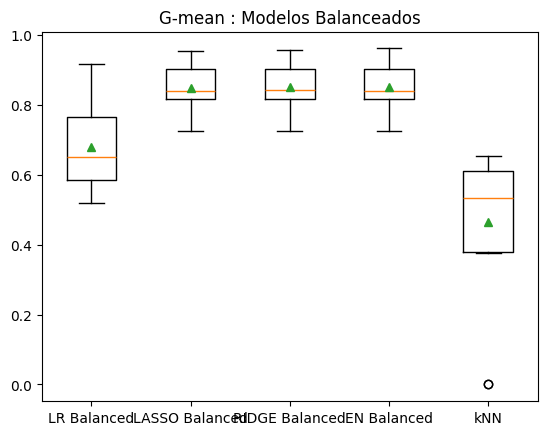

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
import numpy as np
import matplotlib.pyplot as plt

# Definimos los modelos con class_weight='balanced'
def mis_modelos2():
    modelos, nombres = list(), list()

    modelos.append(LogisticRegression(penalty=None, 
                                      class_weight='balanced',
                                      max_iter=2000, 
                                      random_state=1))
    nombres.append('LR Balanced')

    modelos.append(LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      class_weight='balanced',
                                      max_iter=2000, 
                                      random_state=1))
    nombres.append('LASSO Balanced')

    modelos.append(LogisticRegression(penalty='l2',
                                      class_weight='balanced',
                                      max_iter=2000, 
                                      random_state=1))
    nombres.append('RIDGE Balanced')

    modelos.append(LogisticRegression(penalty='elasticnet',
                                      l1_ratio=0.5,
                                      solver='saga',
                                      class_weight='balanced',
                                      max_iter=5000, 
                                      random_state=1))
    nombres.append('EN Balanced')

    modelos.append(KNeighborsClassifier(n_neighbors=5))  # k-NN no tiene class_weight
    nombres.append('kNN')

    return modelos, nombres

# Crear y evaluar modelos balanceados
modelos2, nombres2 = mis_modelos2()
resultados_balanceados = list()

print('Resultados de Validación - Modelos Balanceados:')

for i in range(len(modelos2)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos2[i])])
    cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    
    scores = cross_validate(pipeline,
                            Xtv,
                            np.ravel(ytv),
                            scoring={'m_geo': mi_metrica},  # Solo usamos G-Mean
                            cv=cv1)

    resultados_balanceados.append(scores['test_m_geo'])

    print(nombres2[i])
    print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
    print()

# Visualización de G-Mean para modelos balanceados
plt.boxplot(resultados_balanceados, tick_labels=nombres2, showmeans=True)
plt.title("G-mean : Modelos Balanceados")
plt.show()

Los resultados muestran una mejora significativa en la métrica G-Mean después de aplicar class_weight='balanced' en los modelos de Regresión Logística. 

**Tendencias generales observadas:**

- Los modelos balanceados de regresión logística han mejorado considerablemente su desempeño en G-Mean en comparación con los modelos sin class_weight='balanced'.
- k-NN sigue con un G-Mean bajo (0.464), lo que confirma que no maneja bien el desbalanceo de clases.
- Ridge, ElasticNet y LASSO tienen los mejores valores de G-Mean (~0.85), con baja variabilidad (desviación estándar baja).
- LR Balanced (Regresión Logística sin regularización) tiene un G-Mean menor (~0.679), pero ha mejorado respecto a la versión sin class_weight='balanced'.


**INTERPRETACIÓN DE CADA MODELO**

**LR Balanced (G-Mean = 0.679 ± 0.118)**
- Mejoró respecto a la versión sin balanceo (~0.759 → 0.679).
- Sin embargo, sigue por debajo de los modelos regularizados (LASSO, Ridge, ElasticNet).
- Esto se debe a que la regresión logística estándar sin regularización tiene menos capacidad de ajuste en datos desbalanceados, incluso con class_weight='balanced'.
- Puede estar sobreajustando algunas muestras de la clase mayoritaria.

**LASSO Balanced (G-Mean = 0.849 ± 0.069)**
- Gran mejora respecto a la versión sin balanceo (~0.689 → 0.849).
- Menor variabilidad que LR Balanced (desviación estándar de 0.069 vs 0.118).
- LASSO no solo balancea las clases con class_weight='balanced', sino que también elimina variables irrelevantes, lo que mejora la estabilidad del modelo.

**RIDGE Balanced (G-Mean = 0.852 ± 0.070)**
- Mayor G-Mean que LR Balanced (~0.679 → 0.852).
- Similar a LASSO y ElasticNet, pero con una penalización diferente.
- Ridge reduce el impacto de variables poco importantes sin eliminarlas completamente (a diferencia de LASSO).
- Es más estable en problemas con colinealidad.

**EN Balanced (G-Mean = 0.851 ± 0.070)**
- Similar a Ridge y LASSO en desempeño (~0.85 G-Mean).
- Buena estabilidad (baja desviación estándar).
- ElasticNet combina LASSO y Ridge (selecciona variables y reduce el impacto de otras).
- Se comporta de manera muy similar a Ridge y LASSO en este problema.

**k-NN (G-Mean = 0.464 ± 0.204)**
- Sigue con un G-Mean bajo (~0.464).
- Tiene la mayor variabilidad (±0.204), lo que indica inestabilidad.
- k-NN no tiene un mecanismo de balanceo de clases, por lo que sigue favoreciendo la clase mayoritaria.
- Es probable que k-NN esté clasificando muchas instancias de la clase minoritaria como la clase mayoritaria.
- Su alta desviación estándar indica que su rendimiento varía mucho dependiendo de la partición de los datos.


**Lo que muestra el gráfico**
- LASSO, Ridge y ElasticNet tienen valores de G-Mean cercanos a 0.85 con poca variabilidad.
- LR Balanced tiene menor G-Mean (~0.679) con mayor dispersión, lo que indica que no es tan estable como los modelos regularizados.
- k-NN tiene el peor rendimiento y la mayor variabilidad, confirmando que no maneja bien el desbalance de clases.

**Conclusion**
- Los modelos de regresión logística balanceados con LASSO, Ridge y ElasticNet son los mejores en este problema.
- Ridge y ElasticNet ofrecen una ligera ventaja sobre LASSO en estabilidad (menor desviación estándar).
- El modelo LR Balanced mejora, pero sigue siendo inferior a sus versiones regularizadas.
- k-NN sigue siendo un mal modelo para este problema, ya que no maneja bien el desbalanceo.
- **Modelo recomendado:** Ridge Balanced o ElasticNet Balanced, ya que combinan estabilidad y alto G-Mean.

### **Ejercicio - 4**

4a) Selecciona el que consideres sea el mejor modelo encontrado hasta ahora y utilízalo para obtener los gráficos curva-ROC y curva-PR, así como los valores de sus áreas bajo la curva. Sigue utilizando los conjuntos de entrenamiento y validación.

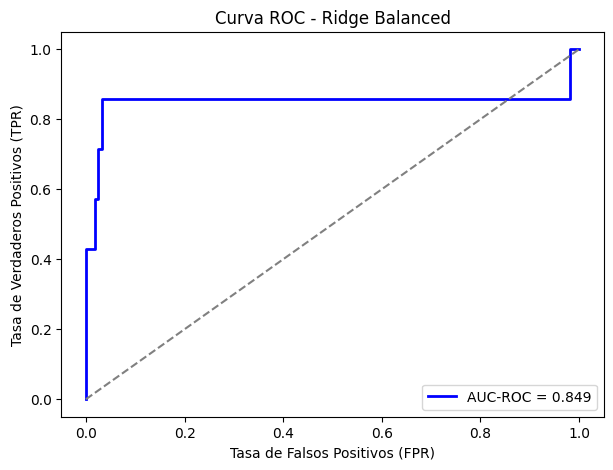

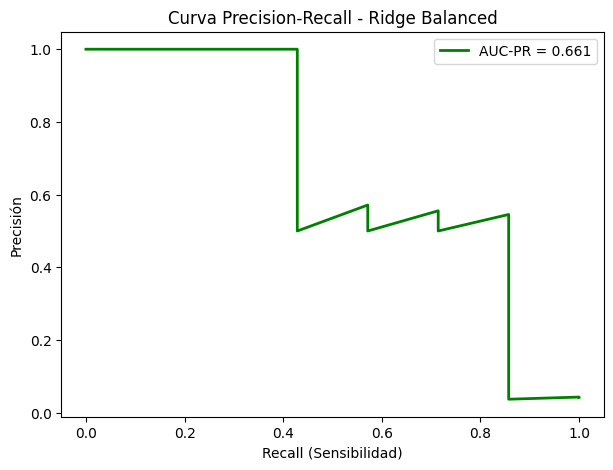

AUC-ROC del mejor modelo: 0.849
AUC-PR del mejor modelo: 0.661


In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Crear un pipeline con normalización y regresión logística balanceada
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de los datos
    ('model', LogisticRegression(penalty='l2', class_weight='balanced', solver='saga', max_iter=5000, random_state=1))
])

# Entrenar el modelo con el conjunto de entrenamiento
pipeline.fit(Xtrain, ytrain)

# Obtener el modelo entrenado dentro del pipeline
mejor_modelo = pipeline.named_steps['model']

# Predecir probabilidades en el conjunto de validación
y_scores = pipeline.predict_proba(Xval)[:, 1]  # Probabilidad de la clase positiva

# ====== Curva ROC ======
fpr, tpr, _ = roc_curve(yval, y_scores)  # Calcular puntos de la curva ROC
roc_auc = auc(fpr, tpr)  # Área bajo la curva ROC (AUC-ROC)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC-ROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea base (clasificador aleatorio)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Ridge Balanced")
plt.legend(loc="lower right")
plt.show()

# ====== Curva Precision-Recall (PR) ======
precision, recall, _ = precision_recall_curve(yval, y_scores)  # Calcular curva PR
pr_auc = auc(recall, precision)  # Área bajo la curva PR (AUC-PR)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='green', lw=2, label=f'AUC-PR = {pr_auc:.3f}')
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precision-Recall - Ridge Balanced")
plt.legend(loc="upper right")
plt.show()

# Mostrar los valores de AUC
print(f"AUC-ROC del mejor modelo: {roc_auc:.3f}")
print(f"AUC-PR del mejor modelo: {pr_auc:.3f}")

4b) Incluye tus conclusiones de los gráficos obtenidos en el inciso anterior.

**Curva ROC (Receiver Operating Characteristic):**

- Mide la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR).
- El AUC-ROC (Área Bajo la Curva ROC) es 0.849, lo que indica un modelo con buena capacidad de discriminación (idealmente, un modelo perfecto tendría un AUC-ROC de 1.0).

**Curva Precision-Recall:**

- Evalúa la relación entre precisión y recall (sensibilidad), que es clave en problemas con clases desbalanceadas.
- El AUC-PR (Área Bajo la Curva Precision-Recall) es 0.661, lo que sugiere un rendimiento moderado en términos de precisión y sensibilidad.

**Interpretación**
- Un AUC-ROC de 0.849 indica que el modelo es bastante bueno para diferenciar entre clases positivas y negativas.
- Un AUC-PR de 0.661 sugiere que el modelo tiene un desempeño aceptable en términos de precisión y sensibilidad, aunque no es excepcional.
- En la mayoría de los casos, la Curva Precision-Recall es más relevante cuando se trabaja con datos desbalanceados, ya que la métrica ROC puede dar resultados demasiado optimistas. Sin embargo, un AUC-PR de 0.661 es razonable, aunque podría mejorarse.

### **Ejercicio - 5**

Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido.

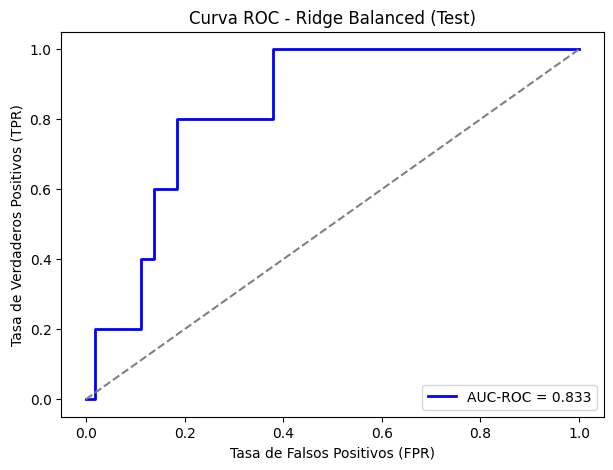

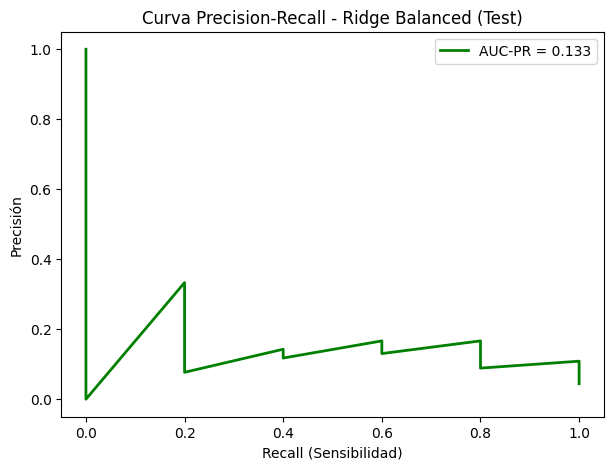

AUC-ROC del modelo Ridge Balanced en Test: 0.833
AUC-PR del modelo Ridge Balanced en Test: 0.133


In [17]:
# Predecir probabilidades en el conjunto de prueba
y_test_scores = pipeline.predict_proba(Xtest)[:, 1]  # Probabilidad de la clase positiva

# ====== Curva ROC en conjunto de prueba ======
fpr_test, tpr_test, _ = roc_curve(ytest, y_test_scores)  # Calcular puntos de la curva ROC
roc_auc_test = auc(fpr_test, tpr_test)  # Área bajo la curva ROC (AUC-ROC)

plt.figure(figsize=(7, 5))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'AUC-ROC = {roc_auc_test:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea base (clasificador aleatorio)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Ridge Balanced (Test)")
plt.legend(loc="lower right")
plt.show()

# ====== Curva Precision-Recall en conjunto de prueba ======
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_scores)  # Calcular curva PR
pr_auc_test = auc(recall_test, precision_test)  # Área bajo la curva PR (AUC-PR)

plt.figure(figsize=(7, 5))
plt.plot(recall_test, precision_test, color='green', lw=2, label=f'AUC-PR = {pr_auc_test:.3f}')
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precision-Recall - Ridge Balanced (Test)")
plt.legend(loc="upper right")
plt.show()

# Mostrar los valores de AUC en conjunto de prueba
print(f"AUC-ROC del modelo Ridge Balanced en Test: {roc_auc_test:.3f}")
print(f"AUC-PR del modelo Ridge Balanced en Test: {pr_auc_test:.3f}")


**Curva ROC - Ridge Balanced (Test)**
- AUC-ROC = 0.833, lo que indica que el modelo sigue teniendo buena capacidad para diferenciar entre las clases.
- La curva ROC se mantiene por encima de la diagonal (clasificador aleatorio), aunque se observa una menor suavidad en la curva debido a un menor número de puntos de prueba.
- La ligera disminución de 0.849 (validación) → 0.833 (test) es esperada y sugiere que el modelo generaliza bien.

**Curva Precision-Recall - Ridge Balanced (Test)**
- AUC-PR = 0.133, lo cual es muy bajo comparado con el resultado en validación (0.661).
- La curva muestra una caída pronunciada en precisión conforme aumenta el recall, indicando que el modelo tiene dificultad para identificar correctamente las muestras positivas sin generar demasiados falsos positivos.
- Esto sugiere que el modelo puede estar sobrestimando la clase negativa (sesgo hacia la clase mayoritaria), lo cual es problemático en datos desbalanceados.

**Conclusión**
- AUC-ROC sigue siendo decente (0.833), por lo que el modelo mantiene buena capacidad de clasificación en general.
- AUC-PR es preocupante (0.133), lo que indica que el modelo no logra un buen balance entre precisión y recall en el conjunto de prueba.
- Se debe de ajustar el umbral de decisión para mejorar la precisión y recall. Además, considerar otras técnicas de balanceo de clases como SMOTE, submuestreo o pesos más agresivos, y probar modelos más robustos como Random Forest o XGBoost.

### **Ejercicio - 6**

**Evaluación del Modelo Ridge Balanced**
- En validación, el modelo mostró un AUC-ROC de 0.849 y un AUC-PR de 0.661, lo que indicaba un buen rendimiento en términos generales.
- En prueba (test), el AUC-ROC se mantuvo alto (0.833), pero el AUC-PR cayó drásticamente a 0.133, lo que indica que el modelo tiene dificultades para capturar correctamente la clase positiva en escenarios reales.
- Esto sugiere que el modelo funciona razonablemente bien en clasificación general (ROC), pero es deficiente en contextos con clases desbalanceadas (Precision-Recall).

**Implicaciones de los Resultados**
- La caída en AUC-PR sugiere un sesgo hacia la clase mayoritaria. El modelo predice la mayoría de los positivos como negativos, afectando la precisión y recall.
- El alto AUC-ROC sugiere que el modelo aún puede diferenciar bien entre clases, lo que indica que ajustar el umbral de decisión podría mejorar el balance entre precisión y recall.

**Mejoras**
- Ajuste del umbral de decisión para encontrar un equilibrio entre precisión y recall, en lugar de depender únicamente de la predicción estándar del modelo.
- Técnicas de balanceo de datos como SMOTE o submuestreo de la clase mayoritaria.
- Pruebas con modelos más robustos como XGBoost, Random Forest o modelos de ensamble para mejorar la predicción de la clase minoritaria.
- Optimización de hiperparámetros, especialmente en la regularización y el balance de pesos.

**Reflexión General**
- Se exploraron métricas clave para evaluar modelos de clasificación en problemas desbalanceados.
- Se compararon resultados en validación y prueba, identificando una posible brecha de generalización.
- Se comprendió la importancia de utilizar múltiples métricas (ROC y PR) para evaluar modelos en problemas de clasificación.
- La actividad permitió identificar limitaciones y plantear mejoras prácticas para optimizar el desempeño del modelo.

En conclusión, aunque el modelo Ridge Balanced muestra un buen desempeño en términos de AUC-ROC, su baja capacidad de predicción de la clase positiva según AUC-PR indica que aún hay margen de mejora. Para optimizar su utilidad en aplicaciones reales, es necesario ajustar el umbral de decisión, aplicar técnicas de balanceo de clases o probar modelos más avanzados.

## **<<< Fin de la Actividad de la Semana - curvas ROC y PR >>>**